
<table width="100%" style="padding:0; margin-left:-6px;">
    <tr style="padding=0;" width="100%">
        <td width="auto">
           <hr style="border:2px solid darkblue">
            <h1> nb2. Query a catalogue</h1>
           <hr style="border:2px solid darkblue">
        </td>
        <td width="60px">
           <img src="ALMAsmall.png" align="right"/> 
        </td>
    </tr>
</table>    
        
In this notebook three functions are presented which query a (moderately long) list of sources from a catalogue: 

* By coordinate
* By resolved name using Sesame
* By ALMA source name

For lists with a very large number of sources, run one query per block of 100 sources. See Example 2b and Example 2d.

-------------

The relevant columns in the ALMA Archive datasets are 
* *s_ra*, *s_dec* (RA and Dec in degress)
* *s_region* (STC-S footprint of the observation) 
* *target_name* (source name)
 
--------- ----- -----





In [1]:
import astropy
import astropy.coordinates
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pyvo
import matplotlib.pyplot as plt

service = pyvo.dal.TAPService("https://almascience.eso.org/tap")      # for the EU ALMA TAP service

# service = pyvo.dal.TAPService("https://almascience.nao.ac.jp/tap")  # for the EA ALMA TAP service
# service = pyvo.dal.TAPService("https://almascience.nrao.edu/tap")   # for the NA ALMA TAP service

<hr style="border:2px solid darkblue"> </hr>

## Query list of coordinates

<hr style="border:2px solid darkblue"> </hr>


In [2]:
def query_coordinate_list(service, ra_list, dec_list, radius):
    """Runs a single query for an entire list of coordinates. Query only 100 or less coordinates in one go.
    
       service        pyvo TAPService instance           
       ra_list        List of Right Ascension values in decimal degrees
       dec            List of Declination values in decimal degrees
       radius         Search radius in decimal degrees
           
       returns        pandas table
    """
    
    conditionlist = [f"INTERSECTS(CIRCLE('ICRS',{c[0]},{c[1]},{radius}),s_region)=1" for c in zip(ra_list, dec_list)]
    
    query = f"""
            SELECT *
            FROM ivoa.obscore
            WHERE {" OR ".join(conditionlist)}"""
    
    return service.search(query).to_table().to_pandas()

<hr style="border:2px solid darkblue"> </hr>

## Query list of resolved names

<hr style="border:2px solid darkblue"> </hr>

In [3]:
def query_resolved_source_name_list(service, source_name_list, radius):
    """Resolves the list of source names with Sesame and runs a coordinate search on them
    
       service           pyvo TAPService instance           
       source_name_list  list with source names
           
       returns           pandas table
    """
    
    coordinates = []
    for source in source_name_list:
        try:
            coordinates.append(astropy.coordinates.SkyCoord.from_name(source))
        except astropy.coordinates.name_resolve.NameResolveError:
            print(f"Warning: source '{source}' could not be resolved by Sesame.")
            
    return query_coordinate_list(service, [c.ra.degree for c in coordinates], [c.dec.degree for c in coordinates], radius)
    

<hr style="border:2px solid darkblue"> </hr>


## Query list of ALMA source names
<hr style="border:2px solid darkblue"> </hr>



In [4]:
def query_alma_source_name_list(service, source_name_list):
    """queries for list of source names as given by the PI in the ALMA proposals
    
       service            pyvo TAPService instance           
       source_name_lis    complete source name 
           
       returns            pandas table
    """
    
    query = f"""  
            SELECT *  
            FROM ivoa.obscore  
            WHERE target_name in ('{"','".join(source_name_list)}') """
    
    return service.search(query).to_table().to_pandas()

-----------------

## Example 2a: Query a catalogue of high-z quasars

First we import a catalogue of high redshift quasars from [VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR), using astroquery:

In [5]:
from astroquery.vizier import Vizier
catalog_list = Vizier.get_catalogs('J/ApJS/227/11')
highzqso_catalog = catalog_list['J/ApJS/227/11/highzqso']
print(f"Number of (limited) rows in the catalog: {len(highzqso_catalog)}")

Number of (limited) rows in the catalog: 50


Note: VizieR limits the number of catalogue entries to 50 per default. We will now use the RA and Dec coordinates in the catalogue to do the search in the ALMA archive. 

In [6]:
ra_list = highzqso_catalog['RAJ2000']
dec_list = highzqso_catalog['DEJ2000']

We now query the ALMA archive:


In [7]:
results = query_coordinate_list(service, ra_list, dec_list, 0.01)
results.head(5) ### show only 5, for visualization purposes

access_url access_format  \
0  http://almascience.org/aq?member_ous_id=uid://...     text/html   
1  http://almascience.org/aq?member_ous_id=uid://...     text/html   
2  http://almascience.org/aq?member_ous_id=uid://...     text/html   
3  http://almascience.org/aq?member_ous_id=uid://...     text/html   
4  http://almascience.org/aq?member_ous_id=uid://...     text/html   

      proposal_id data_rights  gal_longitude  gal_latitude  \
0  2011.0.00206.S      Public     143.742975    -61.898944   
1  2011.0.00206.S      Public     143.742975    -61.898944   
2  2011.0.00206.S      Public     143.742975    -61.898944   
3  2011.0.00206.S      Public     143.742975    -61.898944   
4  2011.0.00243.S      Public     166.654305    -60.934934   

             obs_publisher_did obs_collection facility_name instrument_name  \
0  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
1  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
2  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
3  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
4  ADS/JAO.ALMA#2011.0.00243.S           ALMA           JAO            ALMA   

                   obs_id dataproduct_type  calib_level      target_name  \
0  uid://A002/X391d0b/X22            image            2       J0129-0035   
1  uid://A002/X391d0b/X22            image            2       J0129-0035   
2  uid://A002/X391d0b/X22            image            2       J0129-0035   
3  uid://A002/X391d0b/X22            image            2       J0129-0035   
4  uid://A002/X3ff4ae/X36            image            2  CFHQSJ0210-0456   

        s_ra     s_dec     s_fov                                  s_region  \
0  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
1  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
2  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
3  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
4  32.554958 -4.939142  0.006483  Circle ICRS 32.554958 -4.939142 0.003242   

   s_resolution         t_min         t_max  t_exptime  t_resolution  \
0      0.473461  56069.496754  56069.574857    2661.12       2661.12   
1      0.473461  56069.496754  56069.574857    2661.12       2661.12   
2      0.473461  56069.496754  56069.574857    2661.12       2661.12   
3      0.473461  56069.496754  56069.574857    2661.12       2661.12   
4      0.542146  56112.416643  56149.305258    6168.96       6168.96   

     em_min    em_max  em_res_power pol_states  \
0  0.001066  0.001073    9002.45608    /XX/YY/   
1  0.001022  0.001029    9386.45608    /XX/YY/   
2  0.001058  0.001066    9064.45608    /XX/YY/   
3  0.001015  0.001022    9450.45608    /XX/YY/   
4  0.001158  0.001167    8284.55000    /XX/YY/   

                                 o_ucd band_list  em_resolution  \
0  phot.flux.density;phys.polarization         7       9.593760   
1  phot.flux.density;phys.polarization         7       9.593760   
2  phot.flux.density;phys.polarization         7       9.593760   
3  phot.flux.density;phys.polarization         7       9.593760   
4  phot.flux.density;phys.polarization         6       9.593943   

                                             authors  \
0  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
1  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
2  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
3  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
4  Ando, Ryo; Kohno, Kotaro; Tamura, Yoichi; Izum...   

                                        pub_abstract  publication_year  \
0  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
1  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
2  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
3  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
4  

We can now plot the distribution of ALMA observed quasars from the chosen catalogue.

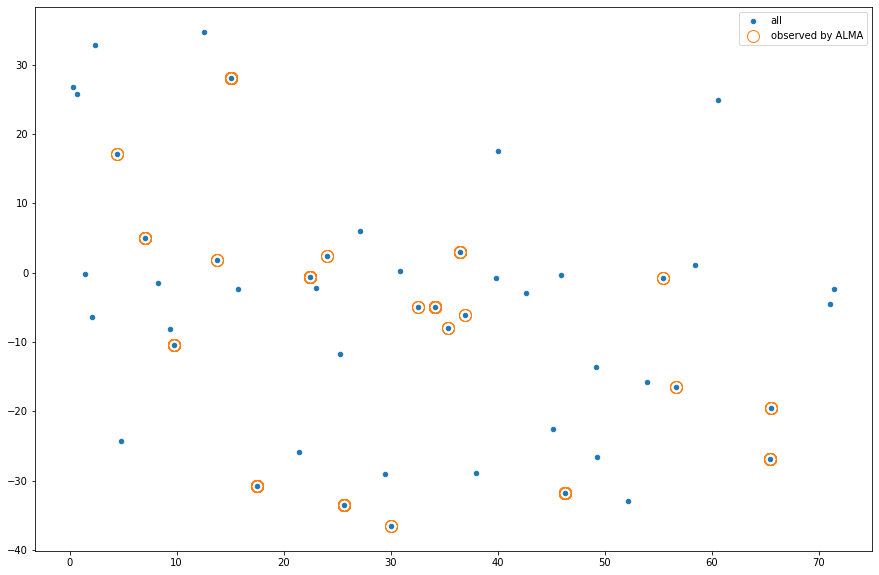

In [8]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(ra_list, dec_list, ls='', marker='.', ms=9, label='all')
plt.plot(results['s_ra'],results['s_dec'], ls='', marker='o', ms=12, fillstyle='none', label='observed by ALMA')
plt.legend()

Please run several queries in case the number of sources in your list is very large.

-----------------

## Example 2b: Query a large catalogue with many sources



Not more than 100 sources should be submitted in a single query. For large catalogues, several queries should be submitted consecutively. Explicitly telling VizieR that no limit shall be placed on the results to return, we obtain:

In [9]:
Vizier.ROW_LIMIT=999999999

catalog_list = Vizier.get_catalogs('J/ApJS/227/11')
highzqso_catalog = catalog_list['J/ApJS/227/11/highzqso']
print(f"Number of (unlimited) rows in the catalog: {len(highzqso_catalog)}")
ra_list = highzqso_catalog['RAJ2000']
dec_list = highzqso_catalog['DEJ2000']

Number of (unlimited) rows in the catalog: 173


We will now use the RA and Dec coordinates in the catalogue to do the search in the ALMA archive in chunks of 100 results. These results are then combined back into a single pandas table.

In [10]:
result = pd.concat([query_coordinate_list(service, ra_list[i:i+100], dec_list[i:i+100], 0.01) for i in range(0, len(ra_list), 100)])

In [11]:
print(f"Number of ALMA rows returned for the {len(highzqso_catalog)} catalog entries: {len(result)}")
results.head(5) ### show only 5, for visualization purposes

Number of ALMA rows returned for the 173 catalog entries: 704


access_url access_format  \
0  http://almascience.org/aq?member_ous_id=uid://...     text/html   
1  http://almascience.org/aq?member_ous_id=uid://...     text/html   
2  http://almascience.org/aq?member_ous_id=uid://...     text/html   
3  http://almascience.org/aq?member_ous_id=uid://...     text/html   
4  http://almascience.org/aq?member_ous_id=uid://...     text/html   

      proposal_id data_rights  gal_longitude  gal_latitude  \
0  2011.0.00206.S      Public     143.742975    -61.898944   
1  2011.0.00206.S      Public     143.742975    -61.898944   
2  2011.0.00206.S      Public     143.742975    -61.898944   
3  2011.0.00206.S      Public     143.742975    -61.898944   
4  2011.0.00243.S      Public     166.654305    -60.934934   

             obs_publisher_did obs_collection facility_name instrument_name  \
0  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
1  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
2  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
3  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
4  ADS/JAO.ALMA#2011.0.00243.S           ALMA           JAO            ALMA   

                   obs_id dataproduct_type  calib_level      target_name  \
0  uid://A002/X391d0b/X22            image            2       J0129-0035   
1  uid://A002/X391d0b/X22            image            2       J0129-0035   
2  uid://A002/X391d0b/X22            image            2       J0129-0035   
3  uid://A002/X391d0b/X22            image            2       J0129-0035   
4  uid://A002/X3ff4ae/X36            image            2  CFHQSJ0210-0456   

        s_ra     s_dec     s_fov                                  s_region  \
0  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
1  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
2  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
3  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
4  32.554958 -4.939142  0.006483  Circle ICRS 32.554958 -4.939142 0.003242   

   s_resolution         t_min         t_max  t_exptime  t_resolution  \
0      0.473461  56069.496754  56069.574857    2661.12       2661.12   
1      0.473461  56069.496754  56069.574857    2661.12       2661.12   
2      0.473461  56069.496754  56069.574857    2661.12       2661.12   
3      0.473461  56069.496754  56069.574857    2661.12       2661.12   
4      0.542146  56112.416643  56149.305258    6168.96       6168.96   

     em_min    em_max  em_res_power pol_states  \
0  0.001066  0.001073    9002.45608    /XX/YY/   
1  0.001022  0.001029    9386.45608    /XX/YY/   
2  0.001058  0.001066    9064.45608    /XX/YY/   
3  0.001015  0.001022    9450.45608    /XX/YY/   
4  0.001158  0.001167    8284.55000    /XX/YY/   

                                 o_ucd band_list  em_resolution  \
0  phot.flux.density;phys.polarization         7       9.593760   
1  phot.flux.density;phys.polarization         7       9.593760   
2  phot.flux.density;phys.polarization         7       9.593760   
3  phot.flux.density;phys.polarization         7       9.593760   
4  phot.flux.density;phys.polarization         6       9.593943   

                                             authors  \
0  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
1  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
2  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
3  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
4  Ando, Ryo; Kohno, Kotaro; Tamura, Yoichi; Izum...   

                                        pub_abstract  publication_year  \
0  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
1  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
2  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
3  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
4  

We can now plot the distribution of ALMA observed quasars from the chosen catalogue.

-----------------

## Example 2c: Query a list of sources using a name resolver

The function query_resolved_source_name_list will query Sesame for each source name and then query the ALMA TAP service with the returned coordinates. If a source is not known by Sesame (like the 'unknownsourcename' we have put in explicitly), then the function writes out a warning.

In [12]:
source_name_list = ['CenA', 'M83', 'ALESS73.1', 'unknownsourcename'] 
query_resolved_source_name_list(service, source_name_list, 0.01).head(5)

access_url access_format  \
0  http://almascience.org/aq?member_ous_id=uid://...     text/html   
1  http://almascience.org/aq?member_ous_id=uid://...     text/html   
2  http://almascience.org/aq?member_ous_id=uid://...     text/html   
3  http://almascience.org/aq?member_ous_id=uid://...     text/html   
4  http://almascience.org/aq?member_ous_id=uid://...     text/html   

       proposal_id data_rights  gal_longitude  gal_latitude  \
0  2011.0.00008.SV      Public     309.512363     19.416239   
1  2011.0.00008.SV      Public     309.512363     19.416239   
2  2011.0.00008.SV      Public     309.512363     19.416239   
3  2011.0.00008.SV      Public     309.512363     19.416239   
4   2011.0.00294.S      Public     223.796099    -54.451777   

              obs_publisher_did obs_collection facility_name instrument_name  \
0  ADS/JAO.ALMA#2011.0.00008.SV           ALMA           JAO            ALMA   
1  ADS/JAO.ALMA#2011.0.00008.SV           ALMA           JAO            ALMA   
2  ADS/JAO.ALMA#2011.0.00008.SV           ALMA           JAO            ALMA   
3  ADS/JAO.ALMA#2011.0.00008.SV           ALMA           JAO            ALMA   
4   ADS/JAO.ALMA#2011.0.00294.S           ALMA           JAO            ALMA   

                    obs_id dataproduct_type  calib_level  \
0  uid://A002/X259150/X157             cube            2   
1  uid://A002/X259150/X157             cube            2   
2  uid://A002/X259150/X157             cube            2   
3  uid://A002/X259150/X157             cube            2   
4       uid://A001/X6f/X2c            image            2   

            target_name        s_ra      s_dec     s_fov  \
0           Centaurus A  201.360719 -43.020553  0.058089   
1           Centaurus A  201.360719 -43.020553  0.058089   
2           Centaurus A  201.360719 -43.020553  0.058089   
3           Centaurus A  201.360719 -43.020553  0.058089   
4  LESSJ033229.3-275619   53.122208 -27.938694  0.004702   

                                            s_region  s_resolution  \
0  Polygon ICRS 201.401254 -43.032096 201.401354 ...      1.023315   
1  Polygon ICRS 201.401254 -43.032096 201.401354 ...      1.023315   
2  Polygon ICRS 201.401254 -43.032096 201.401354 ...      1.023315   
3  Polygon ICRS 201.401254 -43.032096 201.401354 ...      1.023315   
4          Circle ICRS 53.122208 -27.938694 0.002351      1.035258   

          t_min         t_max  t_exptime  t_resolution    em_min    em_max  \
0  55784.795689  55785.043473    344.261       344.261  0.001221  0.001231   
1  55784.795689  55785.043473    344.261       344.261  0.001212  0.001221   
2  55784.795689  55785.043473    344.261       344.261  0.001297  0.001308   
3  55784.795689  55785.043473    344.261       344.261  0.001287  0.001297   
4  55852.408470  55852.482915    104.832       104.832  0.000857  0.000861   

   em_res_power pol_states                                o_ucd band_list  \
0  251315.70776    /XX/YY/  phot.flux.density;phys.polarization         6   
1  253235.70776    /XX/YY/  phot.flux.density;phys.polarization         6   
2  236599.53752    /XX/YY/  phot.flux.density;phys.polarization         6   
3  238519.53752    /XX/YY/  phot.flux.density;phys.polarization         6   
4   11199.57640    /XX/YY/  phot.flux.density;phys.polarization         7   

   em_resolution                                            authors  \
0     306.959997  Azeez, Jazeel H.; Abidin, Zamri Z.; Hwang, C. ...   
1     306.959997  Azeez, Jazeel H.; Abidin, Zamri Z.; Hwang, C. ...   
2     306.959997  Azeez, Jazeel H.; Abidin, Zamri Z.; Hwang, C. ...   
3     306.959997  Azeez, Jazeel H.; Abidin, Zamri Z.; Hwang, C. ...   
4       9.592993  Chen, Chian-Chou; Smail, Ian; Swinbank, A. M.;...   

                                        pub_abstract  publication_year  \
0  Centaurus A, with its gas-rich elliptical host...              2014   
1  Centaurus A, with its gas-rich elliptical host...              2014   
2  Centaurus A, with its gas-rich ell

-----------------

## Example 2d: Query a long list of sources using a name resolver

We query a lisf of many sources in groups of 100 sources at a time and combine the result into a single pandas dataframe.

In [13]:
query = """SELECT DISTINCT(target_name) from ivoa.obscore where target_name like 'NGC____'"""
source_name_list = list(service.search(query).to_table().to_pandas()['(target_name)'].values)

In [14]:
result = pd.concat([query_resolved_source_name_list(service, source_name_list[i:i+100], 0.006) for i in range(0, len(source_name_list), 100)])
print(f"Number of ALMA rows returned for the {len(source_name_list)} sources in the list: {len(result)}")
results.head(5)

Number of ALMA rows returned for the 320 sources in the list: 6252


access_url access_format  \
0  http://almascience.org/aq?member_ous_id=uid://...     text/html   
1  http://almascience.org/aq?member_ous_id=uid://...     text/html   
2  http://almascience.org/aq?member_ous_id=uid://...     text/html   
3  http://almascience.org/aq?member_ous_id=uid://...     text/html   
4  http://almascience.org/aq?member_ous_id=uid://...     text/html   

      proposal_id data_rights  gal_longitude  gal_latitude  \
0  2011.0.00206.S      Public     143.742975    -61.898944   
1  2011.0.00206.S      Public     143.742975    -61.898944   
2  2011.0.00206.S      Public     143.742975    -61.898944   
3  2011.0.00206.S      Public     143.742975    -61.898944   
4  2011.0.00243.S      Public     166.654305    -60.934934   

             obs_publisher_did obs_collection facility_name instrument_name  \
0  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
1  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
2  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
3  ADS/JAO.ALMA#2011.0.00206.S           ALMA           JAO            ALMA   
4  ADS/JAO.ALMA#2011.0.00243.S           ALMA           JAO            ALMA   

                   obs_id dataproduct_type  calib_level      target_name  \
0  uid://A002/X391d0b/X22            image            2       J0129-0035   
1  uid://A002/X391d0b/X22            image            2       J0129-0035   
2  uid://A002/X391d0b/X22            image            2       J0129-0035   
3  uid://A002/X391d0b/X22            image            2       J0129-0035   
4  uid://A002/X3ff4ae/X36            image            2  CFHQSJ0210-0456   

        s_ra     s_dec     s_fov                                  s_region  \
0  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
1  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
2  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
3  22.493792 -0.594361  0.005630  Circle ICRS 22.493792 -0.594361 0.002815   
4  32.554958 -4.939142  0.006483  Circle ICRS 32.554958 -4.939142 0.003242   

   s_resolution         t_min         t_max  t_exptime  t_resolution  \
0      0.473461  56069.496754  56069.574857    2661.12       2661.12   
1      0.473461  56069.496754  56069.574857    2661.12       2661.12   
2      0.473461  56069.496754  56069.574857    2661.12       2661.12   
3      0.473461  56069.496754  56069.574857    2661.12       2661.12   
4      0.542146  56112.416643  56149.305258    6168.96       6168.96   

     em_min    em_max  em_res_power pol_states  \
0  0.001066  0.001073    9002.45608    /XX/YY/   
1  0.001022  0.001029    9386.45608    /XX/YY/   
2  0.001058  0.001066    9064.45608    /XX/YY/   
3  0.001015  0.001022    9450.45608    /XX/YY/   
4  0.001158  0.001167    8284.55000    /XX/YY/   

                                 o_ucd band_list  em_resolution  \
0  phot.flux.density;phys.polarization         7       9.593760   
1  phot.flux.density;phys.polarization         7       9.593760   
2  phot.flux.density;phys.polarization         7       9.593760   
3  phot.flux.density;phys.polarization         7       9.593760   
4  phot.flux.density;phys.polarization         6       9.593943   

                                             authors  \
0  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
1  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
2  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
3  Champagne, Jaclyn B.; Decarli, Roberto; Casey,...   
4  Ando, Ryo; Kohno, Kotaro; Tamura, Yoichi; Izum...   

                                        pub_abstract  publication_year  \
0  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
1  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
2  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
3  Bright high-redshift quasars (z &gt; 6) hostin...              2013   
4  

-----------------

## Example 2e: Query a list of sources using the ALMA source name

Although in most cases the coordinate query or the source name resolving queries should be preferred, there may be occasions where it is useful to query directly for the source name as given by the PI.

In [15]:
source_name_list = ['CenA', 'M83', 'ALESS73.1'] 
results = query_alma_source_name_list(service, source_name_list)

results.head(5)

access_url access_format  \
0  http://almascience.org/aq?member_ous_id=uid://...     text/html   
1  http://almascience.org/aq?member_ous_id=uid://...     text/html   
2  http://almascience.org/aq?member_ous_id=uid://...     text/html   
3  http://almascience.org/aq?member_ous_id=uid://...     text/html   
4  http://almascience.org/aq?member_ous_id=uid://...     text/html   

      proposal_id data_rights  gal_longitude  gal_latitude  \
0  2011.0.00010.S      Public     309.515914     19.417224   
1  2011.0.00010.S      Public     309.515914     19.417224   
2  2011.0.00010.S      Public     309.515914     19.417224   
3  2011.0.00010.S      Public     309.515914     19.417224   
4  2011.0.00772.S      Public     314.600374     31.972870   

             obs_publisher_did obs_collection facility_name instrument_name  \
0  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
1  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
2  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
3  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
4  ADS/JAO.ALMA#2011.0.00772.S           ALMA           JAO            ALMA   

                    obs_id dataproduct_type  calib_level target_name  \
0  uid://A002/X327408/X217             cube            2        CenA   
1  uid://A002/X327408/X217             cube            2        CenA   
2  uid://A002/X327408/X217             cube            2        CenA   
3  uid://A002/X327408/X217             cube            2        CenA   
4   uid://A002/X3216af/X31             cube            2         M83   

         s_ra      s_dec     s_fov  \
0  201.365063 -43.019112  0.007385   
1  201.365063 -43.019112  0.007385   
2  201.365063 -43.019112  0.007385   
3  201.365063 -43.019112  0.007385   
4  204.269845 -29.862594  0.054640   

                                            s_region  s_resolution  \
0         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
1         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
2         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
3         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
4  Polygon ICRS 204.258830 -29.886906 204.254315 ...      1.140462   

          t_min         t_max  t_exptime  t_resolution    em_min    em_max  \
0  55950.253573  55950.305961   1512.000      1512.000  0.001360  0.001366   
1  55950.253573  55950.305961   1512.000      1512.000  0.001364  0.001369   
2  55950.253573  55950.305961   1512.000      1512.000  0.001372  0.001378   
3  55950.253573  55950.305961   1512.000      1512.000  0.001365  0.001371   
4  56013.300683  56166.036243    757.304       757.304  0.002951  0.002979   

   em_res_power pol_states                                o_ucd band_list  \
0  451534.98200    /XX/YY/  phot.flux.density;phys.polarization         6   
1  450286.77208    /XX/YY/  phot.flux.density;phys.polarization         6   
2  447582.94104    /XX/YY/  phot.flux.density;phys.polarization         6   
3  449784.96600    /XX/YY/  phot.flux.density;phys.polarization         6   
4  208012.55000    /XX/YY/  phot.flux.density;phys.polarization         3   

   em_resolution                                            authors  \
0     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
1     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
2     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
3     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
4     614.003552  Egusa, Fumi; Hirota, Akihiko; Baba, Junichi; M...   

                                        pub_abstract  publication_year  \
0  Centaurus A, with its gas-rich elliptical host...              2017   
1  Centaurus A, with its gas-rich elliptical host...              2017   
2  Centaurus A, with its gas-rich elliptical host...              2017   
3  Centaurus A, with its gas-rich e

-----------------

## Example 2f: Query a long list of sources using the ALMA source 

We query a lisf of many sources in groups of 100 sources at a time and combine the result into a single pandas dataframe.

In [16]:
query = """SELECT DISTINCT(target_name) from ivoa.obscore where target_name like 'NGC____'"""
source_name_list = list(service.search(query).to_table().to_pandas()['(target_name)'].values)

In [17]:
result = pd.concat([query_alma_source_name_list(service, source_name_list[i:i+100]) for i in range(0, len(source_name_list), 100)])
print(f"Number of ALMA rows returned for the {len(source_name_list)} sources in the list: {len(result)}")
results.head(5)

Number of ALMA rows returned for the 320 sources in the list: 4611


access_url access_format  \
0  http://almascience.org/aq?member_ous_id=uid://...     text/html   
1  http://almascience.org/aq?member_ous_id=uid://...     text/html   
2  http://almascience.org/aq?member_ous_id=uid://...     text/html   
3  http://almascience.org/aq?member_ous_id=uid://...     text/html   
4  http://almascience.org/aq?member_ous_id=uid://...     text/html   

      proposal_id data_rights  gal_longitude  gal_latitude  \
0  2011.0.00010.S      Public     309.515914     19.417224   
1  2011.0.00010.S      Public     309.515914     19.417224   
2  2011.0.00010.S      Public     309.515914     19.417224   
3  2011.0.00010.S      Public     309.515914     19.417224   
4  2011.0.00772.S      Public     314.600374     31.972870   

             obs_publisher_did obs_collection facility_name instrument_name  \
0  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
1  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
2  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
3  ADS/JAO.ALMA#2011.0.00010.S           ALMA           JAO            ALMA   
4  ADS/JAO.ALMA#2011.0.00772.S           ALMA           JAO            ALMA   

                    obs_id dataproduct_type  calib_level target_name  \
0  uid://A002/X327408/X217             cube            2        CenA   
1  uid://A002/X327408/X217             cube            2        CenA   
2  uid://A002/X327408/X217             cube            2        CenA   
3  uid://A002/X327408/X217             cube            2        CenA   
4   uid://A002/X3216af/X31             cube            2         M83   

         s_ra      s_dec     s_fov  \
0  201.365063 -43.019112  0.007385   
1  201.365063 -43.019112  0.007385   
2  201.365063 -43.019112  0.007385   
3  201.365063 -43.019112  0.007385   
4  204.269845 -29.862594  0.054640   

                                            s_region  s_resolution  \
0         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
1         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
2         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
3         Circle ICRS 201.365063 -43.019112 0.003692      1.330912   
4  Polygon ICRS 204.258830 -29.886906 204.254315 ...      1.140462   

          t_min         t_max  t_exptime  t_resolution    em_min    em_max  \
0  55950.253573  55950.305961   1512.000      1512.000  0.001360  0.001366   
1  55950.253573  55950.305961   1512.000      1512.000  0.001364  0.001369   
2  55950.253573  55950.305961   1512.000      1512.000  0.001372  0.001378   
3  55950.253573  55950.305961   1512.000      1512.000  0.001365  0.001371   
4  56013.300683  56166.036243    757.304       757.304  0.002951  0.002979   

   em_res_power pol_states                                o_ucd band_list  \
0  451534.98200    /XX/YY/  phot.flux.density;phys.polarization         6   
1  450286.77208    /XX/YY/  phot.flux.density;phys.polarization         6   
2  447582.94104    /XX/YY/  phot.flux.density;phys.polarization         6   
3  449784.96600    /XX/YY/  phot.flux.density;phys.polarization         6   
4  208012.55000    /XX/YY/  phot.flux.density;phys.polarization         3   

   em_resolution                                            authors  \
0     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
1     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
2     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
3     614.023326  McCoy, Mark; Ott, Jürgen; Meier, David S.; Mul...   
4     614.003552  Egusa, Fumi; Hirota, Akihiko; Baba, Junichi; M...   

                                        pub_abstract  publication_year  \
0  Centaurus A, with its gas-rich elliptical host...              2017   
1  Centaurus A, with its gas-rich elliptical host...              2017   
2  Centaurus A, with its gas-rich elliptical host...              2017   
3  Centaurus A, with its gas-rich e